In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

# Load and check data 

In [ ]:
mdata = sc.read_h5ad('./Macnair_QC_resetX_TRIMMED_BACKUP.h5ad')
mdata

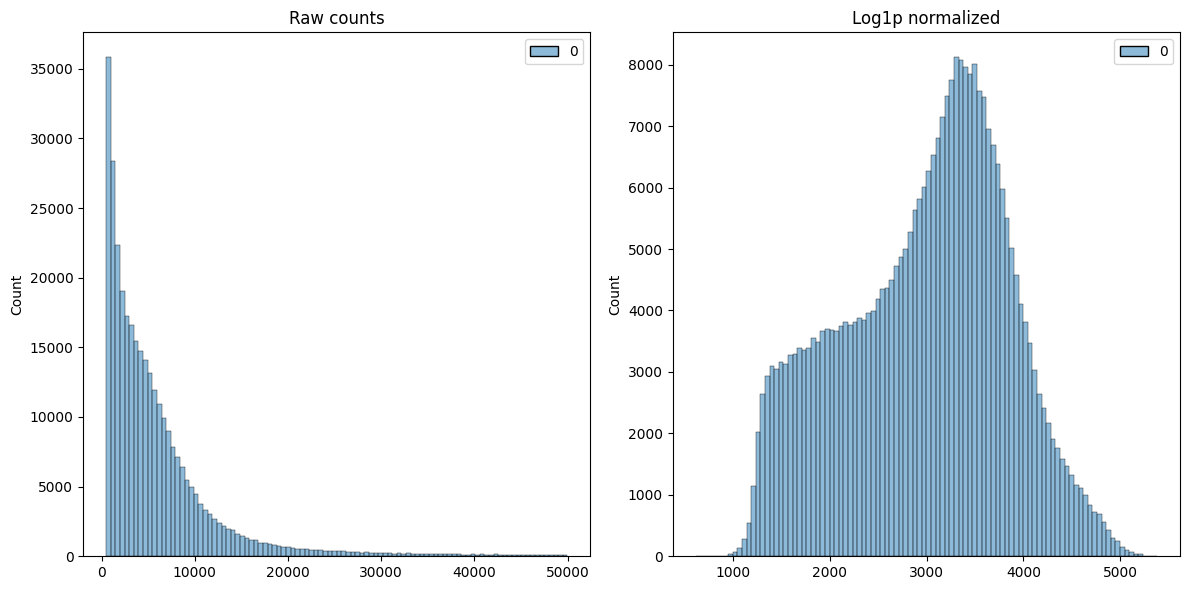

In [5]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(mdata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(mdata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [6]:
print(mdata.X[:10, :10])

  (2, 4)	1.537505303406224
  (6, 4)	1.2002639505735508
  (3, 9)	2.1317280276818393


In [7]:
print(mdata.raw.X[:10, :10])

  (2, 7)	2.0
  (6, 7)	2.0


# Calculate HVG for log1p

In [14]:
mdata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,s_score,g2m_score,phase,cell_cycle_diff,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,pct_counts_ribo,cell_type_eval,library_type,sample_type,organism,system,n_counts
Ind98-Sample2:AAACCCATCCGTCAAA-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,1512,3012.0,1.459854,-0.038595,-0.061295,G1,0.022699,Oligo_B,Oligodendrocytes,oligo_opc-cl01,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.162289,oligodendrocytes,10X 3p kit v3.3,sn,human,1,3012.0
Ind98-Sample2:AAACCCATCCTGGTCT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,639,843.0,1.420118,-0.077440,0.031892,G2M,-0.109333,Micro_B,Microglia,microglia-cl02,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.922571,microglia,10X 3p kit v3.3,sn,human,1,843.0
Ind98-Sample2:AAACGAAGTTGTACGT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,2448,5475.0,0.346905,-0.081434,-0.049244,G1,-0.032190,Oligo_A,Oligodendrocytes,oligo_opc-cl07,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.882552,oligodendrocytes,10X 3p kit v3.3,sn,human,1,5475.0
Ind98-Sample2:AAACGCTAGCGTATGG-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,1000,1346.0,1.112760,-0.088210,-0.084726,G1,-0.003483,Astro_B,Astrocytes,astrocytes-cl03,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.093207,astrocytes,10X 3p kit v3.3,sn,human,1,1346.0
Ind98-Sample2:AAACGCTCAGTTGGTT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,420,562.0,4.609929,0.034034,0.037705,G2M,-0.003671,Oligo_E,Oligodendrocytes,oligo_opc-cl03,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.679484,oligodendrocytes,10X 3p kit v3.3,sn,human,1,562.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64,122,CAL,Amsterdam BB,SPMS,842,1227.0,5.207486,0.006362,-0.053391,S,0.059753,Oligo_B,Oligodendrocytes,oligo_opc-cl01,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34,450,0.301502,inbetween,6H_to_12H,up_to_12H,0.437056,oligodendrocytes,10X 3p kit v3.3,sn,human,1,1227.0
Ind102-Sample4:TTTGTTGAGTAGCTCT-1,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64,122,CAL,Amsterdam BB,SPMS,641,1060.0,7.627119,-0.048246,-0.086150,G1,0.037903,Micro_C,Microglia,microglia-cl03,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34,450,0.301502,inbetween,6H_to_12H,up_to_12H,0.139768,microglia,10X 3p kit v3.3,sn,human,1,1060.0
Ind102-Sample4:TTTGTTGCAGACGATG-1,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64,122,CAL,Amsterdam BB,SPMS,580,820.0,7.299270,-0.084481,-0.032177,G1,-0.052304,Micro_B,Microglia,microglia-cl02,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34,450,0.301502,inbetween,6H_to_12H,up_to_12H,0.322318,microglia,10X 3p kit v3.3,sn,human,1,820.0
Ind102-Sample4:TTTGTTGCATACAGAA-1,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102

In [15]:
unique_batch_counts = mdata.obs['batch'].value_counts()
unique_batch_counts

batch
82     11289
83      9733
110     9715
48      8775
116     8314
       ...  
42       691
51       627
120      571
62       519
71       357
Name: count, Length: 92, dtype: int64

In [8]:
mdata_cr = mdata.copy()
mdata_cr

AnnData object with n_obs × n_vars = 321566 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [9]:
sc.pp.highly_variable_genes(
     adata=mdata_cr, n_top_genes=6000, layer='log1p_norm', flavor='cell_ranger', batch_key='batch', subset=False)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

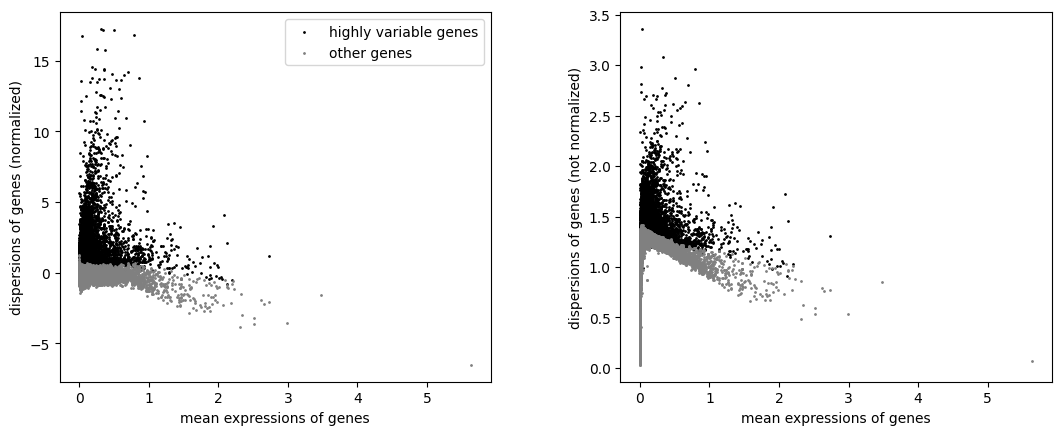

In [10]:
sc.pl.highly_variable_genes(mdata_cr)

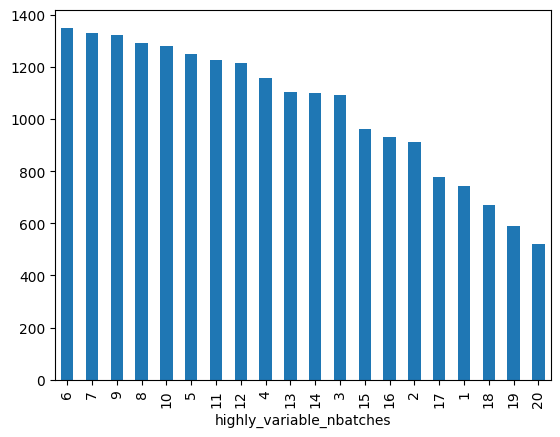

In [13]:
# Slice the series to get the first 20 values
n_batches_top_20 = mdata_cr.var["highly_variable_nbatches"].value_counts().head(20)

# Plot the first 20 values
ax = n_batches_top_20.plot(kind="bar")

# Show the plot
plt.show()

# Calculate HVG for counts

In [37]:
sc.pp.highly_variable_genes(
     adata=mdata_filter, n_top_genes=6000, layer='counts', flavor='seurat_v3', batch_key='batch', subset=False, span=0.5)

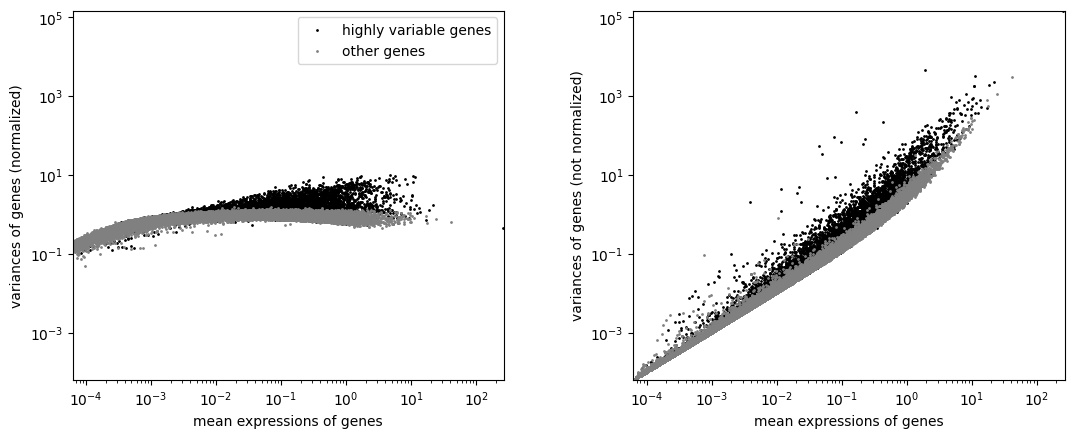

In [38]:
sc.pl.highly_variable_genes(mdata_filter, log=True)

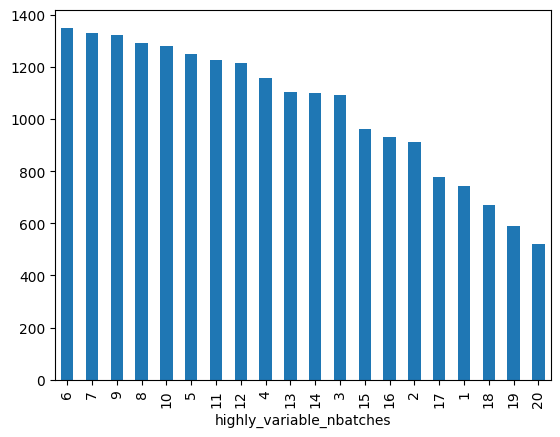

In [39]:
# Slice the series to get the first 20 values
n_batches_top_20 = mdata_cr.var["highly_variable_nbatches"].value_counts().head(20)

# Plot the first 20 values
ax = n_batches_top_20.plot(kind="bar")

# Show the plot
plt.show()

# Explore HVG overlap in single adata

In [40]:
mdata_seur_sub = mdata_filter[:, mdata_filter.var["highly_variable"]].copy()
mdata_seur_sub

AnnData object with n_obs × n_vars = 321566 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [41]:
mdata_cr_sub = mdata_cr[:, mdata_cr.var["highly_variable"]].copy()
mdata_cr_sub

AnnData object with n_obs × n_vars = 321566 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [42]:
common_hvgs=list(set(mdata_seur_sub.var_names) & set(mdata_cr_sub.var_names))
len(common_hvgs)

3146

# Save merged files for downstream use

In [43]:
mdata_seur_sub.write_h5ad('./mdata_seurat_6KHVG.h5ad')

In [44]:
mdata_cr_sub.write_h5ad('./mdata_cellrang_6KHVG.h5ad')